# Preprocessing

Importing necessary packages and other modules

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import verde as vd
import cmocean
import harmonica as hm
import gstatsim as gs 
import skgstat as skg
import itertools
import warnings
from tqdm.auto import tqdm
from utilities import xy_into_grid

from prism_functions import*

### Importing BedMachine

BedMachine is a continent-wide gridded Antarctic data product that includes information such as bed elevation, surface elevation, and ice thickness

In [3]:
bm = xr.open_dataset('BedMachineAntarctica-v3.nc') # imports BedMachine
#xarray is used because it works well with data in terms of coordinates

# trim BedMachine to my study region, which is in the George VI ice shelf region
xmin=-22.5e5
xmax=-16.4975e5
ymin=30e4
ymax=85.025e4
trimmed_bm = bm.where(( xmin< bm.x) & (bm.x < xmax) & (ymin < bm.y) & (bm.y < ymax), drop=True)

### Coarsening BedMachine

This reduces the resolution of the data to 5km (from 500m) so that it is faster to process.

In [4]:
from scipy.stats import mode

def mode_custom(a, axis=None):
    vals, counts = mode(a, axis=axis, nan_policy='omit')  # Handle nan values if necessary
    return vals.squeeze()

trimmed_bm = trimmed_bm.drop_vars(['mapping'])

In [5]:
bm=trimmed_bm.coarsen(x=10,y=10, boundary='pad').mean()
bm['mask']=trimmed_bm['mask'].coarsen(x=10, y=10, boundary='pad').median().astype(int)
bm['source']=trimmed_bm['source'].coarsen(x=10, y=10, boundary='pad').reduce(mode_custom)

Below are some steps to make sure all the data makes sense

In [6]:
# make sure surface is 0 in open water
bm['surface'] = (('y', 'x'), np.where(bm.mask==0, 0, bm.surface))
# make sure thickness is 0 in open water and at exposed rock
ocean_rock_msk = (bm.mask==0)^(bm.mask==1)
bm['thickness'] = (('y', 'x'), np.where(ocean_rock_msk, 0, bm.thickness))
# make sure bed is equal to surface minus thickness under grounded ice
bm['bed'] = (('y', 'x'), np.where(bm.mask==2, bm.surface-bm.thickness, bm.bed))
# make sure surface is equal to bed at exposed rock
bm['bed'] = (('y', 'x'), np.where(bm.mask==1, bm.surface, bm.bed))
# make sure bed not above ice in ice shelf
bed_above_ice_bottom = np.where(bm.bed > (bm.surface-bm.thickness), True, False)
bm['bed'] = (('y', 'x'), np.where(bed_above_ice_bottom, bm.surface-bm.thickness, bm.bed))
# make mask grounded ice where bed was above ice bottom
bm['mask'] = (('y', 'x'), np.where(bed_above_ice_bottom, 2, bm.mask))

### Vizualization of BedMachine Data

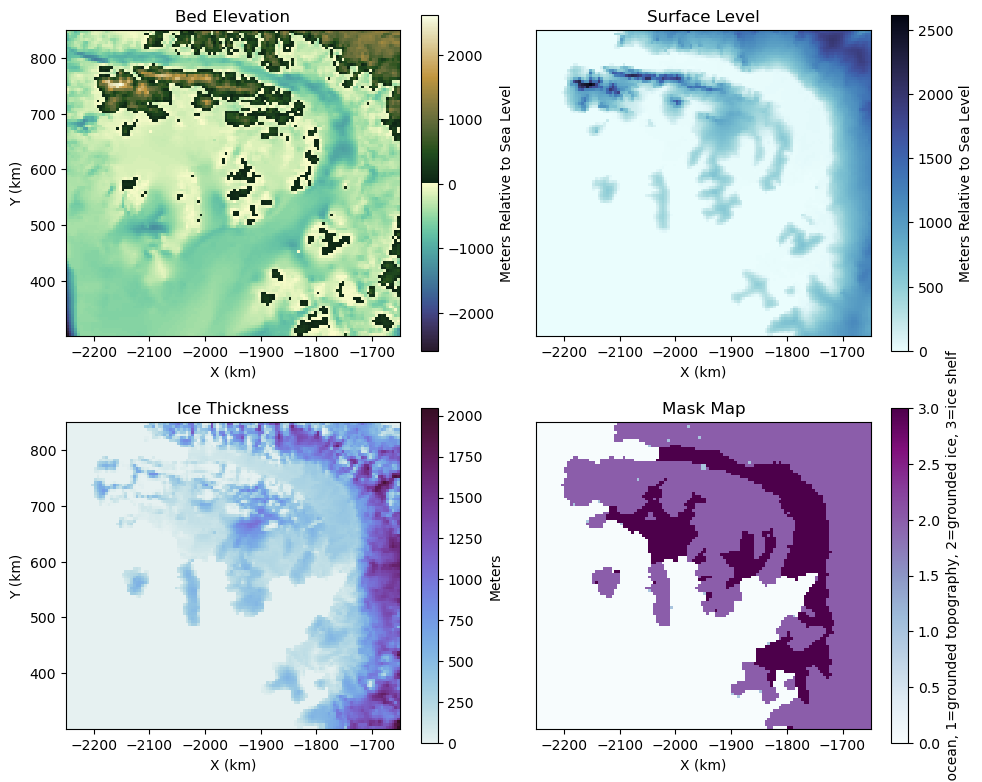

In [7]:
# define the data and titles
data = [
    (bm['bed'], 'Bed Elevation', 'cmo.topo','Meters Relative to Sea Level'),
    (bm['surface'], 'Surface Level', 'cmo.ice_r', 'Meters Relative to Sea Level'),
    (bm['thickness'], 'Ice Thickness','cmo.dense', 'Meters'),
    (bm['mask'], 'Mask Map', 'BuPu', '0=ocean, 1=grounded topography, 2=grounded ice, 3=ice shelf'),
]

# creating the figure 
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # flatten the 2D array of axes for easier iteration

for i, (Z, title, cmap, cbar_label) in enumerate(data):
    ax = axes[i]
    cmap = ax.pcolormesh(bm['x'] / 1000, bm['y'] / 1000, Z, cmap=cmap, shading='auto')
    fig.colorbar(cmap, ax=ax, label=cbar_label)  # adds a colorbar
    ax.set_title(title)
    ax.set_xlabel('X (km)')
    ax.axis('scaled')
    # adds y label to plots in the first colulums
    if i % 2 == 0:  
        ax.set_ylabel('Y (km)') # adds y label to plots in the first colulums
    else: 
        ax.set_yticks([])  
        ax.set_ylabel('') 

plt.tight_layout()
plt.show()


### Importing Gravity Data

The only gravity measurments in my region are from Operation IceBridge

In [8]:
import os
from tqdm.auto import tqdm
# get number of OIB folders for tqdm
num_folders = 0
for folder in os.scandir('OIB_Sander'):
    num_folders += 1

# iterate through folders and ingest data
tables = []
for folder in tqdm(os.scandir('OIB_Sander'), total=num_folders):
    for item in os.scandir(folder.path):
        if item.name.endswith('.txt'):
            tmp = pd.read_table(item.path, header=69, sep='\s+')
            header = tmp.columns[1:]
            tmp = tmp.drop(columns=['FLTENVIRO'])
            tmp.columns = header
            tables.append(tmp)

oib = pd.concat(tables, axis=0)
oib= oib[['LAT', 'LONG', 'PSX', 'PSY', 'FAG070', 'FAG100', 'FAG140', 'FLTENVIRO', 'WGSHGT']]
oib.columns = ['lat', 'lon', 'x', 'y', 'faa70', 'faa100', 'faa140', 'flag', 'height']

  0%|          | 0/155 [00:00<?, ?it/s]

In [9]:
# trimming the data to my region with some padding
oib_trimmed = oib.loc[(oib['x']>xmin+25000) & (oib['x']<xmax-25000) & (oib['y']>ymin+25000) & (oib['y']<ymax-25000),:]

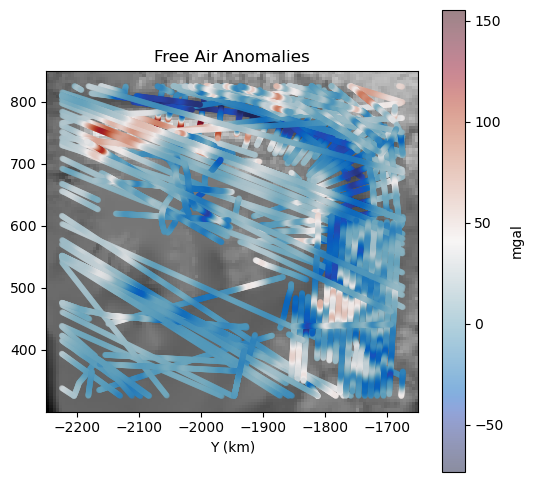

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
bed_map= ax.pcolormesh(bm['x']/1000,bm['y']/1000, bm.bed, cmap='binary_r', shading='auto')
scatter=ax.scatter(oib_trimmed.x[::10]/1000, oib_trimmed.y[::10]/1000, c=oib_trimmed.faa140[::10], s=10, cmap='cmo.balance', alpha=.5)
fig.colorbar(scatter, ax=ax, label='mgal')
ax.set_xlabel('X (km)')
ax.set_xlabel('Y (km)')
ax.set_title('Free Air Anomalies')
ax.axis('scaled')
plt.show()

## Calculating a Target Terrain Effect

The terrain effect refers to all anomalous mass relative to the ellipsoid, which is calculated through the creation of prisms and forward modelling their gravtitational effect. 

### Creating Masks for Different Forms of Matter

This includes water, ice, and rock (both above and below the ellipsoid).

In [11]:
# creating surface and bed elevations referenced to the ellipsoid
bm['surface_ell']=bm['surface']+bm['geoid']
bm['bed_ell']=bm['bed']+bm['geoid']

In [12]:
water_mask=(bm['mask'] == 0) ^ (bm['mask'] == 3)
ice_mask=(bm['mask'] == 2) ^ (bm['mask'] == 3) 
rock_mask=(bm['bed_ell']>=0)
negative_rock_mask=(bm['surface_ell']<0)

### Creating Prisms

In [13]:
def split_prisms(prisms):
    '''
    Function to split prisms above and below the ellipsoid.
    Rerturns combined prisms and an index of which ones are above the ellipsoid.
    '''
    prisms_pos = prisms[prisms[:,5] >= 0, :]
    prisms_neg = prisms[prisms[:,4] < 0, :]
    prisms_pos[prisms_pos[:,4] < 0, 4] = 0.0
    prisms_neg[prisms_neg[:,5] > 0, 5] = 0.0
    prisms = np.vstack([prisms_pos, prisms_neg])
    idx_pos = np.full(prisms.shape[0], False)
    idx_pos[:prisms_pos.shape[0]] = True
    return prisms, idx_pos

In [14]:
X,Y =np.meshgrid(bm['x'],bm['y'])
#spacing=5000m/ 2km
half_space=2500


#water prisims
water_column_array = (bm.surface - bm.thickness - bm.bed).values
water_prisms= np.array([
    X[water_mask] -half_space,
    X[water_mask] +half_space,
    Y[water_mask] -half_space,
    Y[water_mask]+half_space,
    bm['bed_ell'].values[water_mask],
    bm['bed_ell'].values[water_mask]+water_column_array[water_mask]
]).T
# shape matches np.count_nonzero(water_mask),6)
(split_water_prisms, water_positive_indicies)=split_prisms(water_prisms) #returns (split prisims, positive indicies)

#Ice prisims
ice_prisms= np.array([
    X[ice_mask] -half_space,
    X[ice_mask] +half_space,
    Y[ice_mask] -half_space,
    Y[ice_mask]+half_space,
    bm['surface_ell'].values[ice_mask]-bm['thickness'].values[ice_mask], #bottom of ice is surface-thickness
    bm['surface_ell'].values[ice_mask] #top of the ice is surface
]).T
# shape matches np.count_nonzero(ice_mask),6)
(split_ice_prisms, ice_positive_indicies)=split_prisms(ice_prisms) #returns (prisims, positive indicies)

#Rock prisms
# Ensure that the result of np.sum(rock_mask) is converted to an integer
zeros_array = np.zeros(int(np.sum(rock_mask).values))
rock_prisms= np.array([
    X[rock_mask] -half_space,
    X[rock_mask] +half_space,
    Y[rock_mask] -half_space,
    Y[rock_mask]+half_space,
    np.full(int(np.sum(rock_mask).values), 0), #bottom of rock is 0
    bm['bed_ell'].values[rock_mask] #top of the rock is the bed level
]).T
# shape matches np.count_nonzero(rock_mask),6)

#Negative rock prisms
# Ensure that the result of np.sum(rock_mask) is converted to an integer
negative_zeros_array = np.zeros(int(np.sum(negative_rock_mask).values))
negative_rock_prisms= np.array([
    X[negative_rock_mask] -half_space,
    X[negative_rock_mask] +half_space,
    Y[negative_rock_mask] -half_space,
    Y[negative_rock_mask]+half_space,
    bm['surface_ell'].values[negative_rock_mask], #bottom of rock is bed referencced to the ellipsoid
    np.full(int(np.sum(negative_rock_mask).values), 0) #top of the rock is 0
]).T
# shape matches np.count_nonzero((negative_rock_mask),6)

In [15]:
#creating corresponding density arrays
rho_water=1025
rho_ice=917
rho_rock=2670

water_densities= np.where(water_positive_indicies, rho_water, rho_water-rho_rock)
ice_densities=np.where(ice_positive_indicies, rho_ice, rho_ice-rho_rock)
rock_densities=np.full(rock_prisms.shape[0], rho_rock)
negative_rock_densities=np.full(negative_rock_prisms.shape[0], -rho_rock) 

In [16]:
# remove bad water prisms
bad_idx = np.nonzero(split_water_prisms[:,4] > split_water_prisms[:,5])[0]
split_water_prisms = np.delete(split_water_prisms, bad_idx, axis=0)
water_densities = np.delete(water_densities, bad_idx, axis=0)

# remove ice water prisms
bad_idx = np.nonzero(split_ice_prisms[:,4] > split_ice_prisms[:,5])[0]
split_ice_prisms = np.delete(split_ice_prisms, bad_idx, axis=0)
ice_densities = np.delete(ice_densities, bad_idx, axis=0)

# remove bad rock prisms
bad_idx = np.nonzero(rock_prisms[:,4] > rock_prisms[:,5])[0]
rock_prisms = np.delete(rock_prisms, bad_idx, axis=0)
rock_densities = np.delete(rock_densities, bad_idx, axis=0)

# remove bad negative rock prisms
bad_idx = np.nonzero(negative_rock_prisms[:,4] > negative_rock_prisms[:,5])[0]
negative_rock_prisms = np.delete(negative_rock_prisms, bad_idx, axis=0)
negative_rock_densities = np.delete(negative_rock_densities, bad_idx, axis=0)

### Foreward Modelling Graviational Effect

In [17]:
#Creating observation points
gravity=pd.read_csv('gravity.csv')
gravity=gravity.loc[::10,:]
points= (gravity['x'], gravity['y'], gravity['height'])
print('Number of observation points:')
print(len(points[0]))

Number of observation points:
65155


In [18]:
#Format: gz = hm.prism_gravity(coordinates, prisims, densities, field="g_z")
water_gz = hm.prism_gravity(points, split_water_prisms, water_densities, field="g_z")
ice_gz = hm.prism_gravity(points, split_ice_prisms, ice_densities, field="g_z")
rock_gz = hm.prism_gravity(points, rock_prisms, rock_densities, field="g_z")
negative_rock_gz = hm.prism_gravity(points, negative_rock_prisms, negative_rock_densities, field="g_z")

In [19]:
terrain_anomaly=water_gz+ice_gz+rock_gz+negative_rock_gz

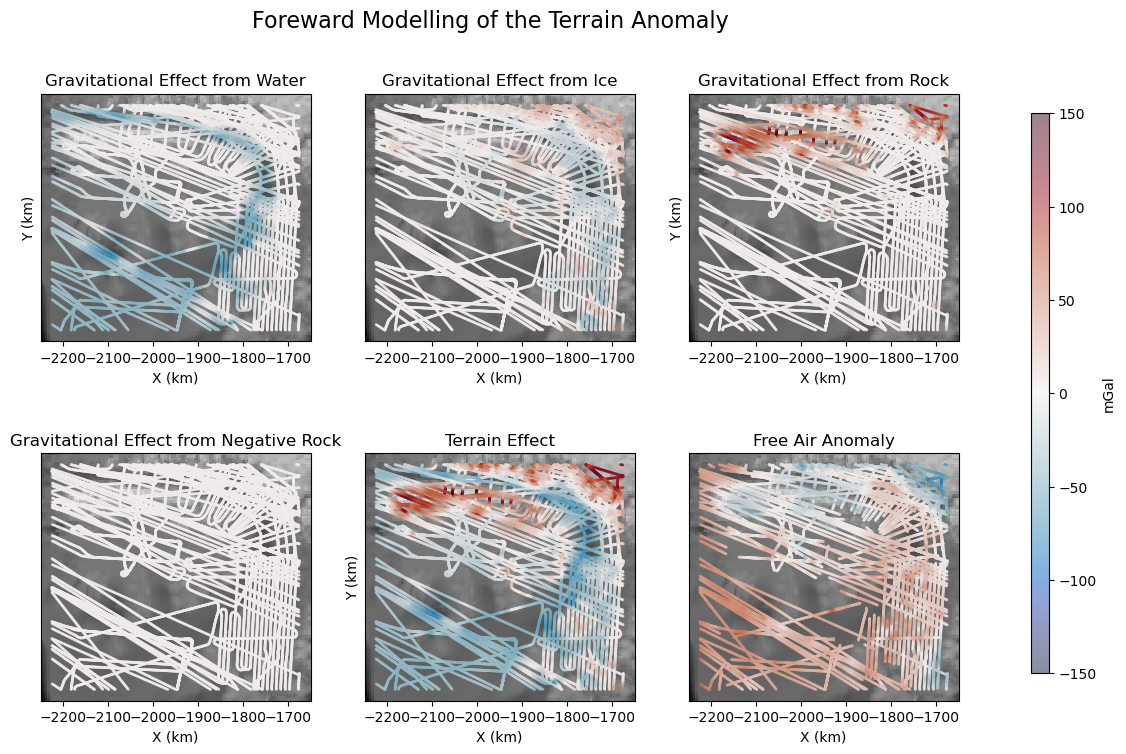

In [20]:
data = [
    (water_gz, 'Gravitational Effect from Water'),
    (ice_gz, 'Gravitational Effect from Ice'),
    (rock_gz, 'Gravitational Effect from Rock'),
    (negative_rock_gz, 'Gravitational Effect from Negative Rock'),
    (terrain_anomaly, 'Terrain Effect'),
    (gravity.faa140 - terrain_anomaly, 'Free Air Anomaly')
]

# creating the figure 
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(12, 8))
(ax1, ax2, ax3), (ax4, ax5, ax6) = axes
axes = axes.flatten()  # flatten the 2D array of axes for easier iteration
norm = plt.Normalize(vmin=-150, vmax=150)
fig.suptitle("Foreward Modelling of the Terrain Anomaly", fontsize=16)

for i, (element, title) in enumerate(data):
    ax = axes[i]
    cmap=ax.pcolormesh(bm.x/1000, bm.y/1000, bm.bed, cmap='binary_r', shading='auto')
    plot = ax.scatter(gravity['x']/1000, gravity['y']/1000, c=element, cmap='cmo.balance', alpha=.5, s=1, norm=norm)
    ax.set_title(title)
    ax.set_xlabel('X (km)')
    ax.axis('scaled')
    # adds y label to plots in the first colulums
    if i % 2 == 0:  
        ax.set_ylabel('Y (km)') # adds y label to plots in the first colulums
    else: 
        ax.set_yticks([])  
        ax.set_ylabel('') 

# Create a shared colorbar
fig.subplots_adjust(right=0.89)  # Adjust layout to make space for colorbar
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])  # Position of the colorbar (left, bottom, width, height)
fig.colorbar(plot, cax=cbar_ax, label='mGal')

#plt.tight_layout() doesn't work with the new color bar so I have to adjust layout manually
plt.subplots_adjust(hspace=0.4)
plt.show()

Note: The "negative" rock does create a gravitational effect, it is just to small to see on this scale.

The terrain effect is equivalent to the complete Bouguer correction (the free air anomaly - the complete Bouguer correction = complete Bouguer disturbance) 

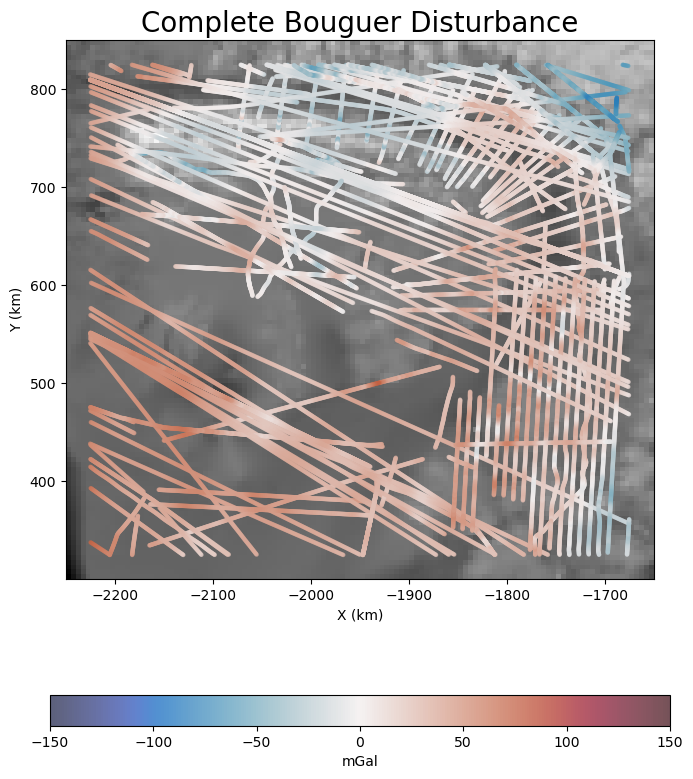

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8,10))
cmap=ax.pcolormesh(bm.x/1000, bm.y/1000, bm.bed, cmap='binary_r', shading='auto')
plot = ax.scatter(gravity['x']/1000, gravity['y']/1000, c=gravity.faa140-terrain_anomaly, cmap='cmo.balance', alpha=.7, s=5, norm=norm)
ax.set_title('Complete Bouguer Disturbance', fontsize=20)
ax.set_xlabel('X (km)')
ax.axis('scaled')
ax.set_ylabel('Y (km)') # adds y label to plots in the first colulums
fig.colorbar(plot, ax=ax, orientation='horizontal', label= 'mGal')

plt.savefig('USPAPP2.png', dpi=300, bbox_inches='tight')
plt.show()

## Upward Continuation of Gravity Measurments

This is done to account for changes in aircraft elevation.

In [20]:
#Creating an ice shelves mask
bm['ice_shelves'] = ((bm.mask ==3).astype(int))
bach = bm.ice_shelves.where((-1920e3<bm.x) & (bm.x<-1810e3) & (530e3<bm.y) & (bm.y<670e3))
strange= bm.ice_shelves.where((-1900e3<bm.x) & (bm.x<-1700000) & (330e3<bm.y) & (bm.y<480e3))

wilkins1=bm.ice_shelves.where((-2150e3<bm.x) & (bm.x<-1940e3) & (630e3<bm.y) & (bm.y<750e3))
wilkins2=bm.ice_shelves.where((-2070e3<bm.x) & (bm.x<-1980e3) & (570e3<bm.y) & (bm.y<630e3))
wilkins = np.where((wilkins1 == 1) ^ (wilkins2 == 1), 1, 0)

george1=bm.ice_shelves.where((-1810e3<bm.x) & (bm.x<-1700000) & (480e3<bm.y) & (bm.y<850000))
george2=bm.ice_shelves.where((-1940e3<bm.x) & (bm.x<-1810e3) & (670e3<bm.y) & (bm.y<850000))
george3=bm.ice_shelves.where((-2250000<bm.x) & (bm.x<-1940e3) & (750e3<bm.y) & (bm.y<850000))
george6 = np.where((george1 == 1) ^ (george2 == 1) ^ (george3==1), 1, 0)

ice_shelves=np.where((george6 == 1) ^ (wilkins == 1) ^ (strange==1) ^(bach==1), 1, 0)

In [21]:
gravity_i=gravity

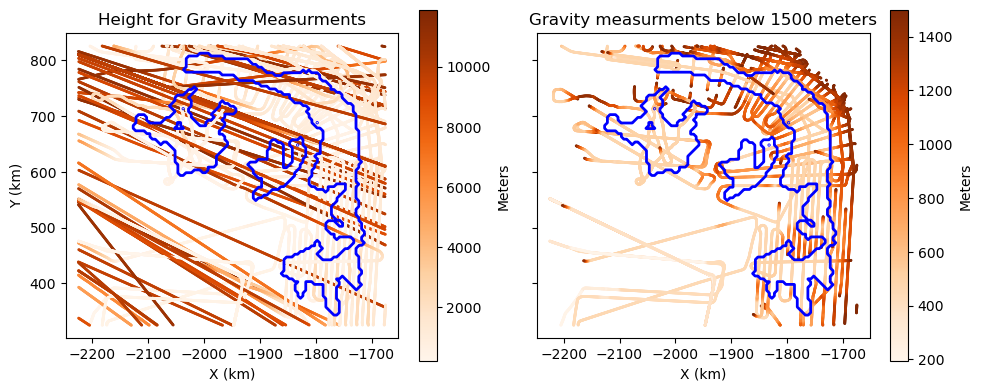

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 4))
scatter1=ax1.scatter(gravity_i.x/1000, gravity_i.y/1000, c=gravity_i.height, s=1, cmap='Oranges')
ax1.contour(bm.x/1000, bm.y/1000,ice_shelves, levels=[0.1], colors='blue', linewidths=2)
fig.colorbar(scatter1, ax=ax1, label='Meters')
ax1.set_title('Height for Gravity Measurments')
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.axis('scaled')
             
height=1500
grav = gravity_i[gravity_i.height < height]
scatter2=ax2.scatter(grav.x/1000, grav.y/1000, c=grav.height, s=1, cmap='Oranges')
ax2.contour(bm.x/1000, bm.y/1000,ice_shelves, levels=[0.1], colors='blue', linewidths=2)
fig.colorbar(scatter2, ax=ax2, label='Meters')
ax2.set_title('Gravity measurments below 1500 meters')
ax2.set_xlabel('X (km)')
ax2.axis('scaled')

plt.tight_layout()
plt.show()

The higher the gravity measurments are, the less reliable they are. I have found that 1500 m is the lowest cutoff height that still provides enough conditioning data.

In [23]:
#Getting rid of NaNs for locations not along flight lines
print(np.isnan(grav.faa140).sum()) 

# Filter rows where grav.faa140 is not NaN for the entire DataFrame
grav = grav[grav.faa140.notna()].reset_index(drop=True)
gravity_i = gravity_i[gravity_i.faa140.notna()].reset_index(drop=True)

# Check if there are any remaining NaN values in the cleaned DataFrame
print(np.isnan(grav['faa140']).sum())


5697
0


Testing out differnt depths for point masses and dampenings (resolutions), this was done using several different combinations of parameters

In [24]:
dampings = [.1]
depths = [4e3, 5e3, 6e3]

parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]

# Gradient Boosted Equivalent sources
equivalent_sources = hm.EquivalentSourcesGB(window_size=20e3)

# Use downsampled data since so dense
coordinates = (grav.x, grav.y, grav.height)

scores = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for params in tqdm(parameter_sets):
        equivalent_sources.set_params(**params)
        score = np.mean(
            vd.cross_val_score(
                equivalent_sources,
                coordinates,
                grav.faa140,
            )
        )
        scores.append(score)
scores

  0%|          | 0/3 [00:00<?, ?it/s]

[np.float64(0.9980939945194095),
 np.float64(0.9980554453010055),
 np.float64(0.9979063123113739)]

In [25]:
best = np.argmax(scores)
print("Best score (on a scale of 0-1):", scores[best])
print("Best parameters:", parameter_sets[best])

Best score (on a scale of 0-1): 0.9980939945194095
Best parameters: {'damping': 0.1, 'depth': 4000.0}


This function elimates all gravity over the cutoff value (height), upscales the gravity data onto the BedMachine grid and creates a 5 km gridded mask of the upward continuted gravity data.

In [26]:
def upward_continue(grav, height, ds, maxdist):
    xx, yy = np.meshgrid(bm.x, bm.y)
    pred_coords = (xx, yy, np.full(xx.shape, height))
    grav_tmp = grav[grav.height < height]
    equivalent_sources = hm.EquivalentSourcesGB(damping=.1, depth=5000, window_size=20e3) #Dampning .1 and depth 4,000 were bmy best parameters from earlier 
    coordinates = (grav_tmp.x.values, grav_tmp.y.values, grav_tmp.height.values)
    equivalent_sources.fit(coordinates, grav_tmp.faa140.values)
    leveled = equivalent_sources.predict(pred_coords)

    dist_msk = vd.distance_mask(coordinates[:2], maxdist, pred_coords[:2])
    masked = np.where(dist_msk, leveled, np.nan)

    return masked

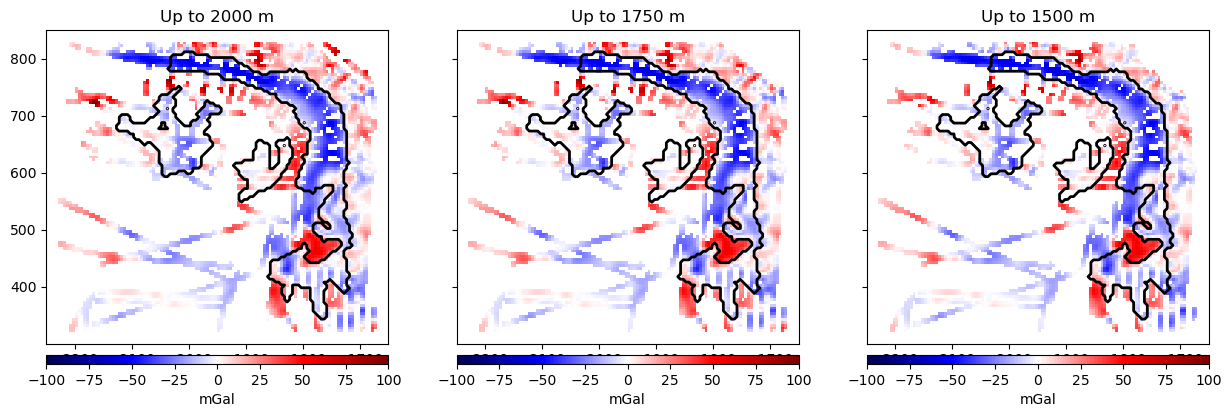

In [27]:
heights = [2000, 1750, 1500]

grav2 = pd.read_csv('gravity.csv')
grav2 = grav2.loc[::10,:]
grav2 = grav2[grav2.faa140.notna()].reset_index(drop=True)

fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)

for ax, h in zip(axs, heights):
    
    leveled_i = upward_continue(grav2, h, bm, 5000) #5000 represents the 5km mask
    
    im = ax.pcolormesh(bm.x/1000, bm.y/1000, leveled_i, vmin=-100, vmax=100, cmap='seismic')
    ax.contour(bm.x/1000, bm.y/1000,ice_shelves, levels=[0.1], colors='black', linewidths=2)
    ax.axis('scaled')
    ax.set_title(f'Up to {h} m')
    plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='mGal', orientation='horizontal')

plt.show()

I selected 1500 m as my height because at this hight it has the best combination of the quantity and quality of conditioning data.

### Creating a data frame for the new gravity values

In [28]:
grav_grid=upward_continue(grav2, 1500, bm, 5000)

xx,yy=np.meshgrid(bm.x,bm.y)
x_grav= xx[~np.isnan(grav_grid)]
y_grav= yy[~np.isnan(grav_grid)]
grav_level=grav_grid[~np.isnan(grav_grid)]

In [29]:
grav_mask= ice_shelves[~np.isnan(grav_grid)]

In [30]:
grav_leveled= pd.DataFrame({
    'x' : x_grav,
    'y' : y_grav,
    'faa' : grav_level,
    'height' : np.full(x_grav.size, 1500),
    'inv_msk' : grav_mask
})

In [31]:
grav_leveled

,x,y,faa,height,inv_msk
0,-2207250.0,827750.0,5.204277,1500,0
1,-2202250.0,827750.0,8.294973,1500,0
2,-2122250.0,827750.0,-6.036941,1500,0
3,-2072250.0,827750.0,-13.153352,1500,0
4,-2067250.0,827750.0,-13.413433,1500,0
...,...,...,...,...,...
4553,-1767250.0,322750.0,22.081350,1500,0
4554,-1737250.0,322750.0,-8.928064,1500,0
4555,-1732250.0,322750.0,-10.239940,1500,0
4556,-1717250.0,322750.0,-6.906666,1500,0


### Recalculating the Bouguer Disturbance

In [32]:
bm.attrs['res'] = 5000

In [33]:
density_dict = {
    'rock' : 2670,
    'ice' : 890,
    'water' : 1030
}

pgen = PrismGen(density_dict)

prisms_dims, densities = pgen.make_prisms(bm, bm.bed.values)

In [34]:
points= (grav_leveled.x, grav_leveled.y, grav_leveled.height)

In [35]:
water_gz = hm.prism_gravity(points, prisms_dims[0], densities[0], field="g_z")
ice_gz = hm.prism_gravity(points, prisms_dims[1], densities[1], field="g_z")
rock_gz = hm.prism_gravity(points, prisms_dims[2], densities[2], field="g_z")
negative_rock_gz = hm.prism_gravity(points,  prisms_dims[3], densities[3], field="g_z")

In [36]:
terrain_anomaly=water_gz + ice_gz + rock_gz + negative_rock_gz

In [37]:
grav_leveled['boug_dist']=grav_leveled.faa-terrain_anomaly

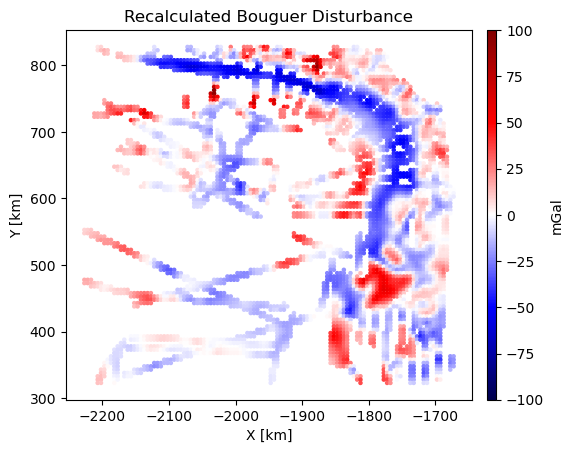

In [38]:
norm=plt.Normalize(vmin=-100, vmax=100)
plt.scatter(grav_leveled.x/1000, grav_leveled.y/1000, c=grav_leveled.boug_dist, s=5, cmap='seismic', norm=norm)
plt.axis('scaled')
plt.title('Recalculated Bouguer Disturbance')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar(pad=0.03, aspect=40, label='mGal')
plt.show()

### Excluding Bouguer Values over the Ice Shelves 

This is done since these values are not very accurate.

In [39]:
grav_filtered = grav_leveled[grav_leveled['inv_msk'] == 0]

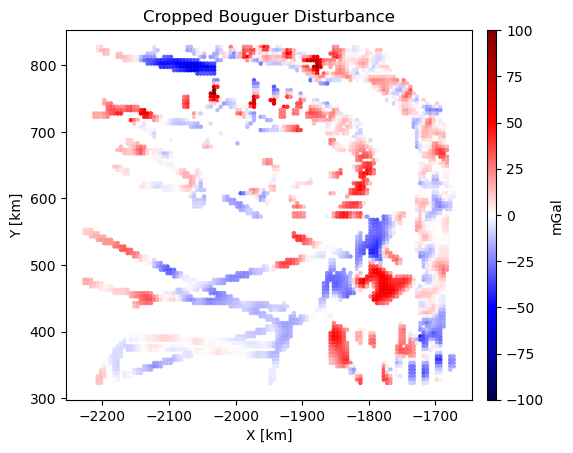

In [40]:
norm=plt.Normalize(vmin=-100, vmax=100)
plt.scatter(grav_filtered.x/1000, grav_filtered.y/1000, c=grav_filtered['boug_dist'],s=5, cmap='seismic', norm=norm)
plt.axis('scaled')
plt.title('Cropped Bouguer Disturbance')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar(pad=0.03, aspect=40, label='mGal')
plt.show()

In [42]:
grav_filtered.to_csv('grav_filtered.csv', index=False)

In [43]:
grav_filtered

,x,y,faa,height,inv_msk,boug_dist
0,-2207250.0,827750.0,5.204277,1500,0,5.204195
1,-2202250.0,827750.0,8.294973,1500,0,8.294878
2,-2122250.0,827750.0,-6.036941,1500,0,-6.040166
3,-2072250.0,827750.0,-13.153352,1500,0,-13.158447
4,-2067250.0,827750.0,-13.413433,1500,0,-13.416959
...,...,...,...,...,...,...
4553,-1767250.0,322750.0,22.081350,1500,0,22.081349
4554,-1737250.0,322750.0,-8.928064,1500,0,-8.928064
4555,-1732250.0,322750.0,-10.239940,1500,0,-10.239940
4556,-1717250.0,322750.0,-6.906666,1500,0,-6.906666
